In [6]:
import scanpy as sc 
import scanpy.external as sce
import torch
import matplotlib.pyplot as plt
import os
os.system("clear")

###############
dataset="human_pancreas_norm_complexBatch"
ncluster=14
###############

data_dir="/home/ubuntu/benchmarking/"+dataset+".h5ad"
adata_raw=sc.read(data_dir)
print(adata_raw)
adata_raw.obs['batch'] = adata_raw.obs.tech
# print_dataset_information(adata_raw,batch_key="BATCH",celltype_key="celltype")

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


Harmony is an algorithm for integrating single-cell data from multiple experiments. This function uses the python port of Harmony, harmonypy, to integrate single-cell data stored in an AnnData object. As Harmony works by adjusting the principal components, this function should be run after performing PCA but before computing the neighbor graph, as illustrated in the example below.

## Raw dataset visualization

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

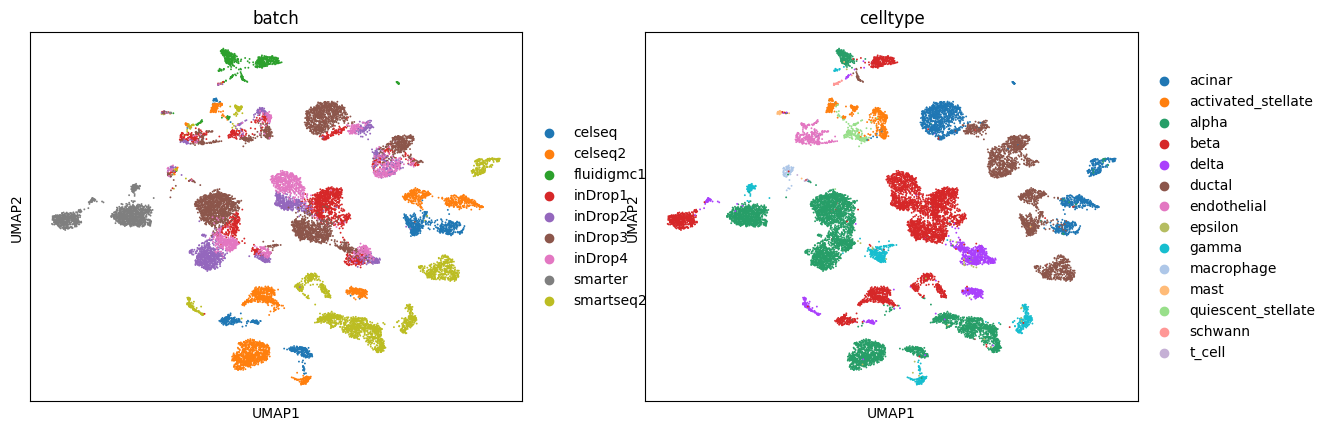

In [7]:
adata_copy=adata_raw.copy()
sc.pp.normalize_total(adata_copy,target_sum=1e4)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy,n_top_genes=2000,subset=True)
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)
sc.pl.umap(adata_copy,color=["batch","celltype"],show=False)

## Harmony integration

In [8]:
sc.tl.pca(adata_raw)

In [9]:
sce.pp.harmony_integrate(adata_raw, 'batch')

2023-08-02 14:40:06,358 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-08-02 14:40:16,174 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-02 14:40:16,295 - harmonypy - INFO - Iteration 1 of 10
2023-08-02 14:40:24,688 - harmonypy - INFO - Iteration 2 of 10
2023-08-02 14:40:35,595 - harmonypy - INFO - Iteration 3 of 10
2023-08-02 14:40:43,797 - harmonypy - INFO - Iteration 4 of 10
2023-08-02 14:40:53,083 - harmonypy - INFO - Iteration 5 of 10
2023-08-02 14:41:02,387 - harmonypy - INFO - Converged after 5 iterations


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

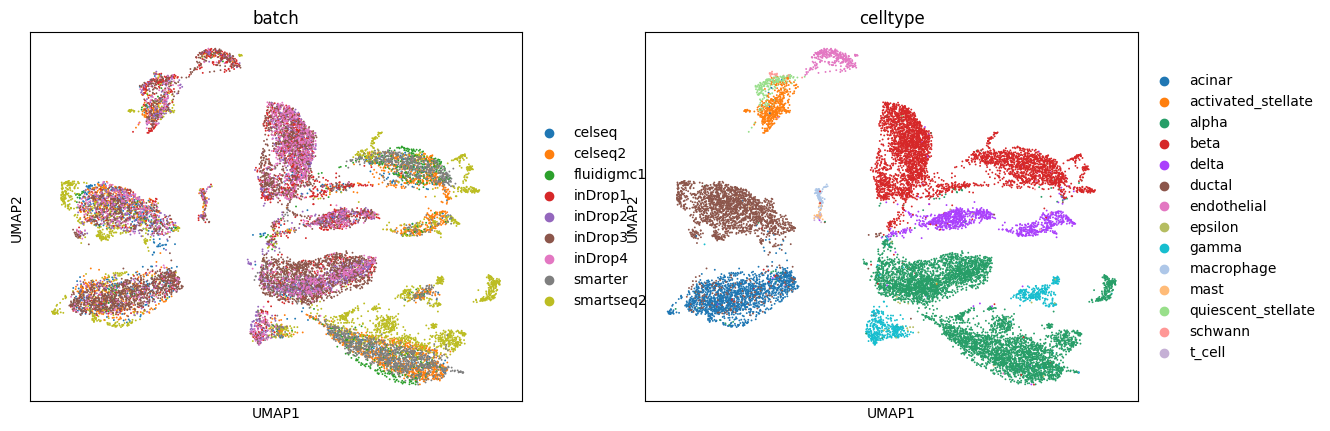

In [10]:
###########################################
sc.pp.neighbors(adata_raw,random_state=0,use_rep="X_pca_harmony")
sc.tl.umap(adata_raw)
###########################################

sc.pl.umap(adata_raw,color=["batch", "celltype"],show=False)
#plt.savefig(save_dir+"scDML_embedding1.png")


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'reassign_cluster'}, xlabel='UMAP1', ylabel='UMAP2'>]

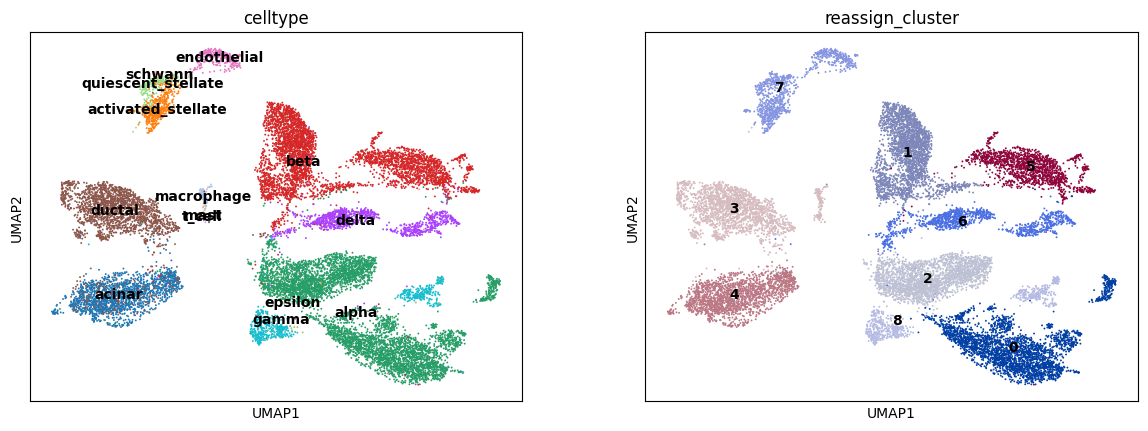

In [17]:
adata_clustering  = adata_raw.copy()
sc.tl.louvain(adata_clustering,resolution=0.085,key_added="leiden")
adata_raw.obs["reassign_cluster"] = adata_clustering.obs.leiden

sc.pl.umap(adata_raw,color=["celltype","reassign_cluster"],legend_loc="on data",show=False)

In [18]:
 adata_clustering.obs.leiden

D101_5         8
D101_43        8
D101_93        8
D102_4         8
D172444_23     8
              ..
Sample_1594    8
Sample_1595    8
Sample_1597    8
Sample_1598    0
Sample_1600    8
Name: leiden, Length: 16382, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

In [19]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ari=adjusted_rand_score(adata_raw.obs["reassign_cluster"],adata_raw.obs["celltype"])
nmi=normalized_mutual_info_score(adata_raw.obs["reassign_cluster"],adata_raw.obs["celltype"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.6323800570039322
NMI=0.7863744772460911
